# What is the circuit library?

Qiskit includes a library of popular circuits, so you don't need to create them from scratch. This includes circuits used in quantum machine learning, quantum chemistry, hardware benchmarking, and more. Use circuits from the library as building blocks to create your quantum programs.

For example, the following code cell uses the `QFT` class to construct a three-qubit quantum Fourier transform circuit.

> **Note:** Circuits from the circuit library are grouped into single instructions, so we decompose the circuit before drawing to show the inner workings

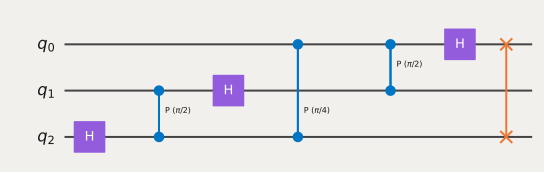

In [1]:
from qiskit.circuit.library import QFT
qft = QFT(3)
qft.decompose().draw('mpl')

These constructors usually offer options to create common variations on these circuits. For example, the following code cell creates an inverse quantum Fourier transform circuit.

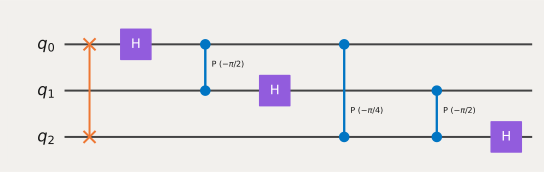

In [2]:
QFT(3, inverse=True).decompose().draw('mpl')

Combine circuits from the library with eachother, or your own circuits using the `compose` method. The following code cell combines the three-qubit quantum Fourier transform circuit with a custom circuit. The optional `qubits` argument tells Qiskit how to map the qubits from one circuit to the other.

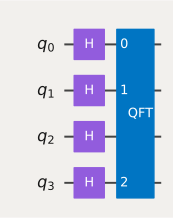

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(4)
qc.h([0, 1, 2, 3])
qc.compose(qft, qubits=[0, 1, 3], inplace=True)
qc.draw('mpl')

## Parameterized circuits

The circuit library includes parameterized circuits. These circuits use values that you can define at a later point in time, which is useful in many variational algorithms. The stand-in for numeric values is `qiskit.circuit.Parameter`.

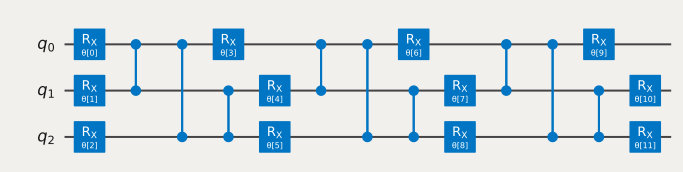

In [4]:
from qiskit.circuit.library import TwoLocal
two_local = TwoLocal(3, 'rx', 'cz')
two_local.decompose().draw('mpl')

You can get a list-like object of the circuit's parameters from the `parameters` attribute.

In [5]:
two_local.parameters

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11])])

And you can use this to bind these parameters to real values using a dictionary of the form `{ Parameter: number }`. To demonstrate, the following code cell binds each parameter in the circuit to `0`.

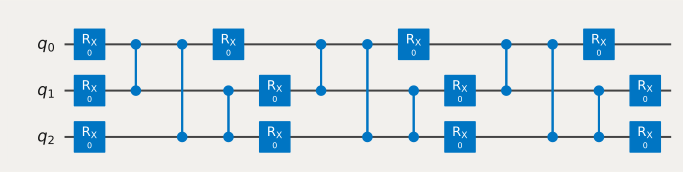

In [6]:
bound_circuit = two_local.bind_parameters({ p: 0 for p in two_local.parameters})
bound_circuit.decompose().draw('mpl')

- See the documentation for `TwoLocal`
- Read more about parameterized circuits.

## Compound gates

The circuit library also includes quantum gates. Some are more fundamental gates (such as the `UGate`),  and other are multi-qubit gates that usually need creating from single and two-qubit gates. To add imported gates to your circuit, use the `append` method; the first argument is the gate, and the next argument is a list of qubits to apply the gate to.

For example, the following code cell creates a circuit with a Hadamard gate, and a multi-controlled-X gate.

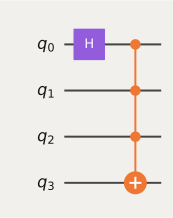

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import HGate, MCXGate
mcx_gate = MCXGate(3)
hadamard_gate = HGate()

qc = QuantumCircuit(4)
qc.append(hadamard_gate, [0])
qc.append(mcx_gate, [0,1,2,3])
qc.draw('mpl')

- Go to the circuit library documentation